In [1]:
import os
import subprocess
import shutil
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import SparkSession
import time
import pyspark
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')

In [2]:
spark = SparkSession.builder.appName("Read Parquet File").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)
spark.conf.set("spark.sql.repl.eagerEval.maxNumRows", 10000)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/03/11 11:19:51 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/03/11 11:19:51 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/03/11 11:19:51 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/03/11 11:19:51 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


In [3]:
# check bucket to load file from
!hadoop fs -ls 'gs://msca-bdp-students-bucket/shared_data/danilm/final_df' | head -n 6

Found 5742 items
-rwx------   3 root root          0 2023-03-11 01:45 gs://msca-bdp-students-bucket/shared_data/danilm/final_df/_SUCCESS
-rwx------   3 root root       8926 2023-03-11 01:37 gs://msca-bdp-students-bucket/shared_data/danilm/final_df/part-00000-09d0b7e3-de22-47dd-b7ea-94767a92b85a-c000.snappy.parquet
-rwx------   3 root root       7682 2023-03-11 01:37 gs://msca-bdp-students-bucket/shared_data/danilm/final_df/part-00001-09d0b7e3-de22-47dd-b7ea-94767a92b85a-c000.snappy.parquet
-rwx------   3 root root       6828 2023-03-11 01:37 gs://msca-bdp-students-bucket/shared_data/danilm/final_df/part-00002-09d0b7e3-de22-47dd-b7ea-94767a92b85a-c000.snappy.parquet
-rwx------   3 root root       6314 2023-03-11 01:37 gs://msca-bdp-students-bucket/shared_data/danilm/final_df/part-00003-09d0b7e3-de22-47dd-b7ea-94767a92b85a-c000.snappy.parquet


In [4]:
%%time
# read the parque sample_file 
final_df = spark.read.format('parquet').load('gs://msca-bdp-students-bucket/shared_data/danilm/final_df')

CPU times: user 6.41 ms, sys: 1.51 ms, total: 7.92 ms
Wall time: 6.93 s


In [5]:
# count of the dataframe
final_df.count()

87313

In [6]:
# testing
final_df.limit(10).toPandas()

,name,screen_name,verified,friends_count,followers_count,location,description,favourites_count,reply_count,retweet_count,created_at,tweet_text
0,Cambridge Computer Science,Cambridge_CL,False,322,7112,"Cambridge, England",Department of Computer Science and Technology at the University of Cambridge. Also known as the Cambridge Computer Laboratory. Established in 1937.,1706,NaN,NaN,Thu Feb 11 23:06:42 +0000 2016,"Hear our colleagues Anil Madhavapeddy @avsm, Director of the Cambridge Centre for Carbon Credits (4C), &amp; @emilyshuckburgh, Professor of Environmental Data Science, speak at Friday's William Pitt Seminar, part of the @CambridgeZero Climate Change Festival. https://t.co/c9AdUmgtap"
1,Chris 🇺🇸,1reconmarine1,False,182,227,None,None,4341,NaN,NaN,Wed Oct 08 14:45:42 +0000 2014,@RNCResearch Kamala Harris you’re a fucking moron three years ago when my son started college he had to teach his four roommates how to do laundry and use a fucking microwave climate change is a hoax
2,James Logan,James3point0,False,348,173,"New Orleans, LA","Nonprofit leader and philanthropist, reformed atty. Long suffering #Knicks #NUFC fan. Bed-Stuy native. All of the opinions outlined here are my own.",345,NaN,NaN,Thu Nov 04 03:12:30 +0000 2010,"The world is so small. My former @FordhamLawNYC professor, the brilliant @SheilaRFoster is moderating a great session on ""Mayors Taking on Climate Change"" at the @EGAconnects Fall Retreat. https://t.co/HjYNYa6zjO"
3,Top Ten Award International Network,TopTenAward,False,4703,471,"British Columbia, CANADA",An International Organization,1835,NaN,NaN,Thu Mar 24 07:36:21 +0000 2016,"S P E C I A L price for SCHOOLs &amp; LIBRARY The “International Manual of Climate Change Control” plus online tests &amp; certificates from Canada. Available in 39,000 bookstores globally\nhttps://t.co/KXbbHXjGkx\ninfo@ecofriendlyeducation.com\n #climatechange #coquitlam #canada"
4,Coquitlam Retweeter,CoquitlamRT,False,328,671,None,All things #Coquitlam as told by fellow tweeters. See pinned tweet. During Emergencies trust: @CityofCoquitlam @cqRCMP @EmergencyInfoBC,41,0.0,2.0,Wed Jul 05 02:08:09 +0000 2017,"S P E C I A L price for SCHOOLs &amp; LIBRARY The “International Manual of Climate Change Control” plus online tests &amp; certificates from Canada. Available in 39,000 bookstores globally\nhttps://t.co/KXbbHXjGkx\ninfo@ecofriendlyeducation.com\n #climatechange #coquitlam #canada"
5,ChukwuemekaForClimate,Agustepo1,False,4552,4711,None,"Climate Change Activist, Sustainable Development Practitioner, Witty Young Man, Risk Taker And An Irredeemable Lover Of Christ. I FOLLOW BACK IMMEDIATELY",53822,0.0,5.0,Fri Jul 21 06:02:13 +0000 2017,"Towards cop 27 African Youth, we call on all government in Africa to review our education system to inculcate climate change across all level of education.Thank you @PACJA1 for paving the way for Youth through the 2nd edition of Nairob summer school on Climate Justice. https://t.co/lOZvHFC3oh"
6,Pallab Lochan Das,pallablochandas,True,272,33101,"Assam, India","Member of Parliament, Tezpur (Assam),\nGeneral Secretary @BJP4Assam,\nFormer Minister, Govt of Assam &\n2-Time MLA",83461,1.0,2.0,Sun Sep 11 13:37:29 +0000 2016,"India’s universities must focus on finding solutions to challenges such as climate change, embracing new technologies to further ‘waste to wealth’ and boosting the circular economy. https://t.co/iJRIEDIY67"
7,Manoharan BJP,Manohar30282223,False,825,620,Thirupor,None,56234,1.0,4.0,Thu Sep 30 01:41:39 +0000 2021,"India’s universities must focus on finding solutions to challenges such as climate change, embracing new technologies to further ‘waste to wealth’ and boosting the circular economy. https://t.co/iJRIEDIY67"
8,Dr.Bharati Pravin Pawar,DrBharatippawar,True,147,23539,"Nashik, India",Union MoS for Health and Family Welfare | Member of Parliament (Dindori),35729,1.0,5.0,Sat Dec 14 09:11:31 +0000 2019,"India’s universities must focus on finding solutions to challenges such as climate

In [7]:
# casting varriables to the appropriate data type
final_df = final_df.withColumn('reply_count', final_df['reply_count'].cast(IntegerType()))
final_df = final_df.withColumn('retweet_count', final_df['retweet_count'].cast(IntegerType()))
final_df = final_df.withColumn('friends_count', final_df['friends_count'].cast(IntegerType()))
final_df = final_df.withColumn('retweet_count', final_df['retweet_count'].cast(IntegerType()))
final_df = final_df.withColumn('favourites_count', final_df['favourites_count'].cast(IntegerType()))

In [8]:
# validating the casts
final_df.printSchema()

root
 |-- name: string (nullable = true)
 |-- screen_name: string (nullable = true)
 |-- verified: boolean (nullable = true)
 |-- friends_count: integer (nullable = true)
 |-- followers_count: long (nullable = true)
 |-- location: string (nullable = true)
 |-- description: string (nullable = true)
 |-- favourites_count: integer (nullable = true)
 |-- reply_count: integer (nullable = true)
 |-- retweet_count: integer (nullable = true)
 |-- created_at: string (nullable = true)
 |-- tweet_text: string (nullable = true)



# Analysis

### Top Twitterers

In [9]:
# create a new column with concatenated name, screen_name entries
final_df =  final_df.withColumn('name_username', concat(col('name'),lit(', '),col('screen_name')))
final_df.limit(5).toPandas()

,name,screen_name,verified,friends_count,followers_count,location,description,favourites_count,reply_count,retweet_count,created_at,tweet_text,name_username
0,Cambridge Computer Science,Cambridge_CL,False,322,7112,"Cambridge, England",Department of Computer Science and Technology at the University of Cambridge. Also known as the Cambridge Computer Laboratory. Established in 1937.,1706,NaN,NaN,Thu Feb 11 23:06:42 +0000 2016,"Hear our colleagues Anil Madhavapeddy @avsm, Director of the Cambridge Centre for Carbon Credits (4C), &amp; @emilyshuckburgh, Professor of Environmental Data Science, speak at Friday's William Pitt Seminar, part of the @CambridgeZero Climate Change Festival. https://t.co/c9AdUmgtap","Cambridge Computer Science, Cambridge_CL"
1,Chris 🇺🇸,1reconmarine1,False,182,227,None,None,4341,NaN,NaN,Wed Oct 08 14:45:42 +0000 2014,@RNCResearch Kamala Harris you’re a fucking moron three years ago when my son started college he had to teach his four roommates how to do laundry and use a fucking microwave climate change is a hoax,"Chris 🇺🇸, 1reconmarine1"
2,James Logan,James3point0,False,348,173,"New Orleans, LA","Nonprofit leader and philanthropist, reformed atty. Long suffering #Knicks #NUFC fan. Bed-Stuy native. All of the opinions outlined here are my own.",345,NaN,NaN,Thu Nov 04 03:12:30 +0000 2010,"The world is so small. My former @FordhamLawNYC professor, the brilliant @SheilaRFoster is moderating a great session on ""Mayors Taking on Climate Change"" at the @EGAconnects Fall Retreat. https://t.co/HjYNYa6zjO","James Logan, James3point0"
3,Top Ten Award International Network,TopTenAward,False,4703,471,"British Columbia, CANADA",An International Organization,1835,NaN,NaN,Thu Mar 24 07:36:21 +0000 2016,"S P E C I A L price for SCHOOLs &amp; LIBRARY The “International Manual of Climate Change Control” plus online tests &amp; certificates from Canada. Available in 39,000 bookstores globally\nhttps://t.co/KXbbHXjGkx\ninfo@ecofriendlyeducation.com\n #climatechange #coquitlam #canada","Top Ten Award International Network, TopTenAward"
4,Coquitlam Retweeter,CoquitlamRT,False,328,671,None,All things #Coquitlam as told by fellow tweeters. See pinned tweet. During Emergencies trust: @CityofCoquitlam @cqRCMP @EmergencyInfoBC,41,0.0,2.0,Wed Jul 05 02:08:09 +0000 2017,"S P E C I A L price for SCHOOLs &amp; LIBRARY The “International Manual of Climate Change Control” plus online tests &amp; certificates from Canada. Available in 39,000 bookstores globally\nhttps://t.co/KXbbHXjGkx\ninfo@ecofriendlyeducation.com\n #climatechange #coquitlam #canada","Coquitlam Retweeter, CoquitlamRT"


In [10]:
# Top 30 Highest Retweets
# Using the sum aggregarion function to add the metric across all tweets posted by the user
top_30_retweets = final_df.groupby('name_username','description').agg(sum('retweet_count')).orderBy('sum(retweet_count)',ascending=False).limit(30).toPandas()

In [11]:
# Investigate profile descriptions to comprehend what is the background of the people who are at the top of the metric aggregation
top_30_retweets

,name_username,description,sum(retweet_count)
0,"Liz ""The Mask Goes Over Your Nose AND Mouth"" Ditz, lizditz","Dyslexia consultant, autism advocate, and blogger. See http://thinkingautismguide.blogspot.com/ for autism advocacy. Pronouns: she/her",36737
1,"twist, pvdork",None,35320
2,"Qaiyima, qai19",None,34740
3,"Fred is FED UP!, FZirm",KEEP IT BLUE in ‘22. Joe and Kamala need both the House and Senate. GQP will kill our Democracy. #BeTheChange4USA 🇺🇸#PRU 🏳️‍🌈Ally,29221
4,"pherne lewis, LewisPherne",None,27571
5,"Karen Shuter, KarenShuter1",Are we there yet?,26508
6,"Donn Lovett, donnlovett","President/CEO, Donn Lovett Agency International Consultant since 1990, Agriculture, Financing, Oil & Gas Exploration & Development. Canada, Oman and Qatar",25984
7,"streedbd, wordwarrior16","Resister sister in ruby red SD. Triple vaxxed, science believer, incl global warming. Trickle down econ = hoax. Put Christ back into hypocrite ""Christians.""",25070
8,"Becky Graves, Cytobeck","Wife,mother,Red Sox fan,microscope jockey,Supernatural fangirl,pluviophile.",24783
9,"sally, sally71004896",Lost,24615


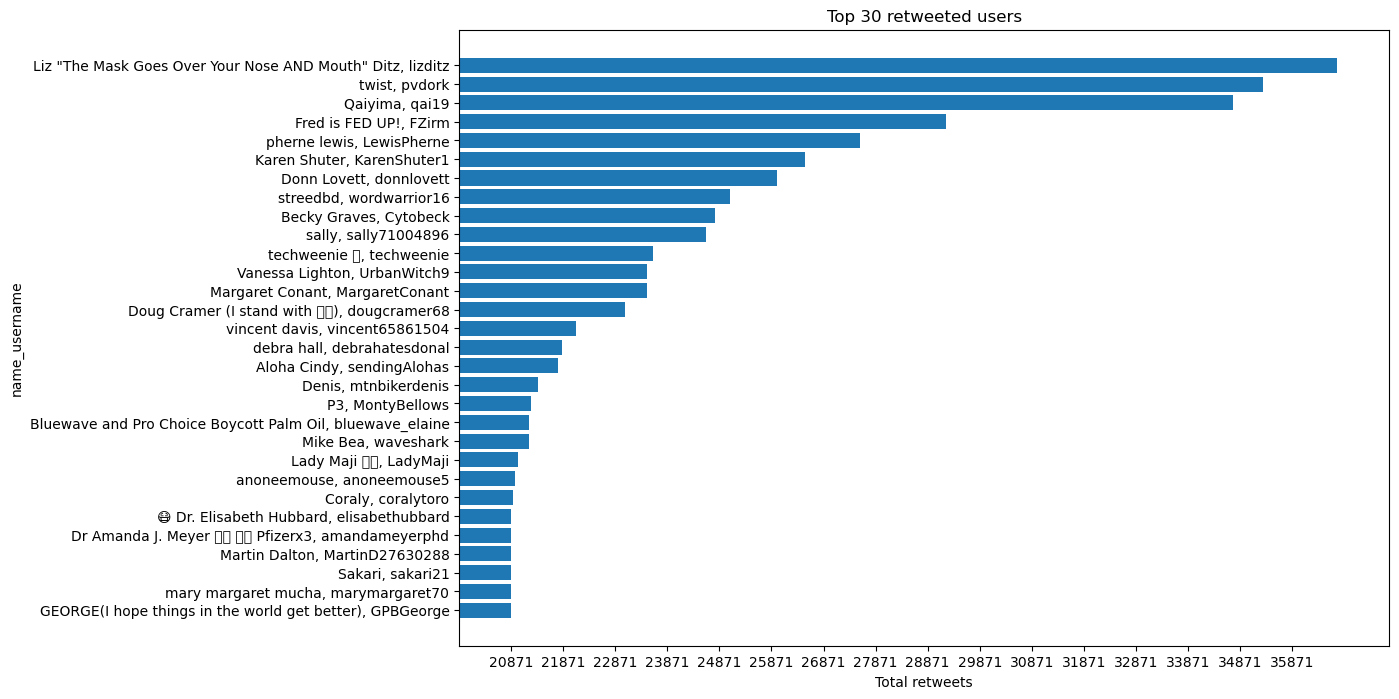

In [58]:
# Bar Chart
plt.figure(figsize=(12, 8))
plt.barh(y=top_30_retweets['name_username'], width=top_30_retweets['sum(retweet_count)'])
plt.xlabel('Total retweets')
plt.xlim(top_30_retweets['sum(retweet_count)'].min()-1000, top_30_retweets['sum(retweet_count)'].max()+1000)
plt.xticks(range(top_30_retweets['sum(retweet_count)'].min(), top_30_retweets['sum(retweet_count)'].max(), 1000))
plt.ylabel('name_username')
plt.title('Top 30 retweeted users')
plt.gca().invert_yaxis()
plt.show()

In [13]:
# Top 30 Highest Replies
# Using the sum aggregarion function to add the metric across all tweets posted by the user
top_30_replies = final_df.groupby('name_username','description').agg(sum('reply_count')).orderBy('sum(reply_count)',ascending=False).limit(30).toPandas()

In [14]:
# Investigate profile descriptions to comprehend what is the background of the people who are at the top of the metric aggregation
top_30_replies

,name_username,description,sum(reply_count)
0,"Liz ""The Mask Goes Over Your Nose AND Mouth"" Ditz, lizditz","Dyslexia consultant, autism advocate, and blogger. See http://thinkingautismguide.blogspot.com/ for autism advocacy. Pronouns: she/her",3947
1,"twist, pvdork",None,3744
2,"Qaiyima, qai19",None,3636
3,"Fred is FED UP!, FZirm",KEEP IT BLUE in ‘22. Joe and Kamala need both the House and Senate. GQP will kill our Democracy. #BeTheChange4USA 🇺🇸#PRU 🏳️‍🌈Ally,2955
4,"techweenie 🌊, techweenie",Vietnam era Army veteran. Too much life experience to be a Republican. Lover of women & cats. COVID19 survivor; now 2M+2P. #LookForTheHelpers,2930
5,"pherne lewis, LewisPherne",None,2729
6,"Kimmyann, kimmyann1111",RIDE OR DIE BLAZER FAN ❤️🖤 CANCER SURVIVOR #Resist #BLM #Justice4Julius\nFollowed by @Dame_Lillard @RoArquette @trailblazers @brookeolzendam,2647
7,"Debbie Howes 🇨🇦❤️🇺🇦, DebbieHowes6","Wife, mother, grandma retired nurse, democratic socialist (self described) politics/news junkie, passionate environmentalist no dms please",2632
8,"Kelly Szentgyorgyi, antipodal","#Trekkie for 56 years. \nSciFi novel, movie & TV series fan. \nDevoted especially to Star Trek, Stargate, The Expanse.\nNO Direct Messages!",2623
9,"debra hall, debrahatesdonal",None,2611


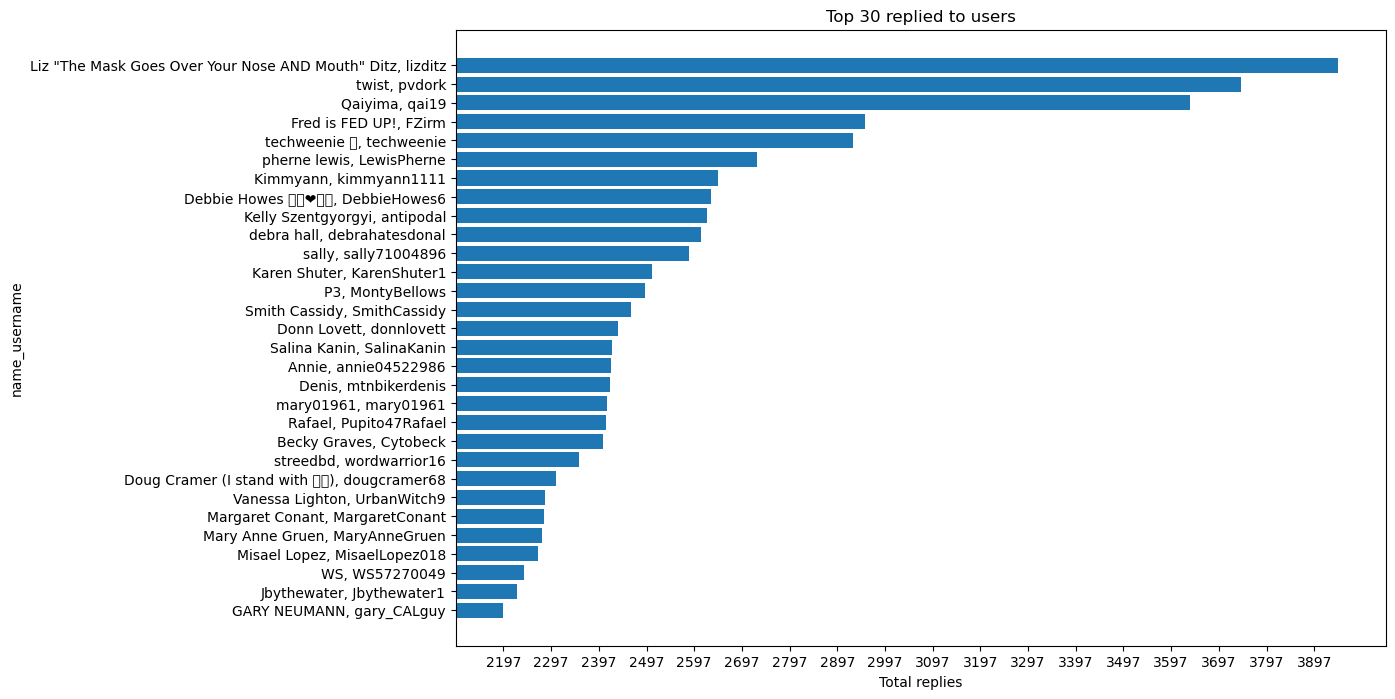

In [59]:
# Bar Chart
plt.figure(figsize=(12, 8))
plt.barh(y=top_30_replies['name_username'], width=top_30_replies['sum(reply_count)'])
plt.xlabel('Total replies')
plt.xlim(top_30_replies['sum(reply_count)'].min()-100, top_30_replies['sum(reply_count)'].max()+100)
plt.xticks(range(top_30_replies['sum(reply_count)'].min(), top_30_replies['sum(reply_count)'].max(), 100))
plt.ylabel('name_username')
plt.title('Top 30 replied to users')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# Top 30 most followed twitterers
# Using the sum aggregarion function to add the metric across all tweets posted by the user
top_30_followers = final_df.groupby('name_username','description').agg(sum('followers_count')).orderBy('sum(followers_count)',ascending=False).limit(30).toPandas()

In [ ]:
top_30_followers

,name_username,description,sum(followers_count)
0,"Reuters, Reuters","Top and breaking news, pictures and videos from Reuters. For more breaking business news, follow @ReutersBiz.",101194692
1,"Fox News, FoxNews","Follow America's #1 cable news network, delivering you breaking news, insightful analysis, and must-see videos. http://foxnews.com/contact",67327504
2,"The New York Times, nytimes",News tips? Share them here: http://nyti.ms/2FVHq9v,53431421
3,"NDTV, ndtv",Breaking news alerts from India.\n\nInstagram: http://instagram.com/ndtv\nYouTube: http://youtube.com/ndtv,51175440
4,"CGTN, CGTNOfficial",CGTN is an international media organization. It aims to provide global audiences with accurate and timely news coverage as well as rich audiovisual services.,39868429
5,"China Xinhua News, XHNews","We are public media for the public good. We don't pursue corporate interests, nor will we yield to the pressure of ideological stigmatization and political bias",36812964
6,"Bloomberg, business",The first word in business news.\nOur newsletters: https://t.co/nWaCxHSKuU\nOur podcasts: https://t.co/096e9xMbPz\nThe Big Take podcast: https://t.co/UqskwXtp5Z,36151972
7,"The Times Of India, timesofindia","News. Views. Analysis. Conversations. India’s No.1 digital news destination, world’s largest-selling English newspaper - A Times Internet Limited Product",28958018
8,"The Hindu, the_hindu",News feeds from India's National Newspaper,23623738
9,"The Washington Post, washingtonpost",Democracy Dies in Darkness,19854097


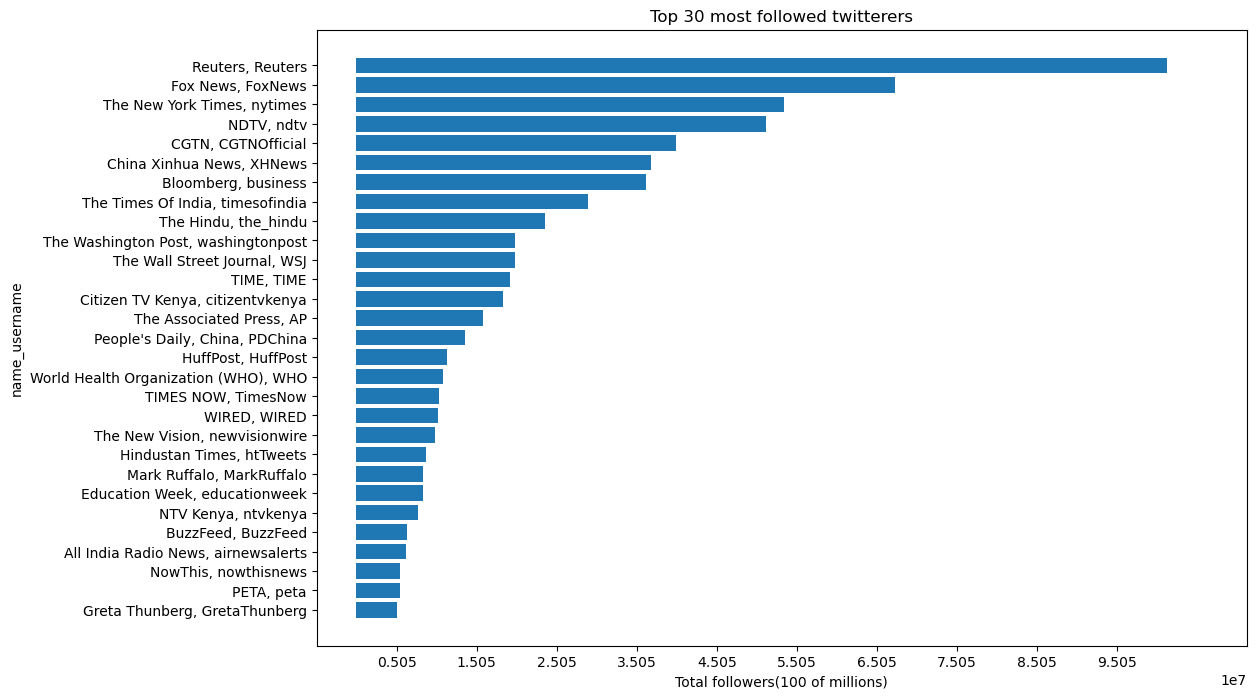

In [63]:
# Bar Chart
plt.figure(figsize=(12, 8))
plt.barh(y=top_30_followers['name_username'], width=top_30_followers['sum(followers_count)'])
plt.xlabel('Total followers(100 of millions)')
plt.xlim(top_30_followers['sum(followers_count)'].min()-10000000, top_30_followers['sum(followers_count)'].max()+10000000)
plt.xticks(range(top_30_followers['sum(followers_count)'].min(), top_30_followers['sum(followers_count)'].max(), 10000000))
plt.ylabel('name_username')
plt.title('Top 30 most followed twitterers')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# Top 30 most befriended twitterers
# Using the sum aggregarion function to add the metric across all tweets posted by the user
top_30_friends = final_df.groupby('name_username','description').agg(sum('friends_count')).orderBy('sum(friends_count)',ascending=False).limit(30).toPandas()

In [ ]:
# Investigate profile descriptions to comprehend what is the background of the people who are at the top of the metric aggregation
top_30_friends

,name_username,description,sum(friends_count)
0,"J.D.™🦄 (🐯Spirit🐢) Nlandu 🇨🇩 🇧🇪 🇫🇷 🇺🇸, iownjd","A✍️@nerdinajock🚀CEO👨🏾‍💼@Twitter (@iOwnDigital™️)—🧢Mogul—Speaker and perpetual optimist, learn—Be cute, but real in this ugly world ✨Ask🗺J.D.🦚@letterstoJD",873287
1,"Svein Tveitdal, tveitdal","Climate Change, Renewable Energy & Nature news. Director Klima 2020, former Assistant Executive Director UN Environment Program. Contact: svein@klima2020.no",722637
2,"Saleemul Huq, SaleemulHuq","Director, @ICCCAD and Senior Associate @IIED. Work on adaptation to climate change. Views presented are my own.",653407
3,"SafetyPin-Daily, SafetyPinDaily","""Striving for social justice is the most valuable thing to do in life."" -- Albert Einstein\n\nA daily source for progressive news and opinions",504889
4,"Jonah De Vries (J.D.) 🇨🇩 🇧🇪 🇫🇷 🇺🇸, iownjd","A @nerdinajock's body ♠️, perpetual optimist 🫂, learn, grow, inform, inspire, engage, empower: Be cute, but real in this ugly world ✨. #WeOwn 💫. 🫂 #Rock 💎",440172
5,"J.D. 🇨🇩 🇧🇪 🇫🇷 🇺🇸, iownjd","A @nerdinajock's body ♠️, perpetual optimist 🫂, learn, grow, inform, inspire, engage, empower: Be cute, but real in this ugly world ✨. #WeOwn 💫. 🫂 #Rock 💎",439682
6,"J.D. 🇨🇩 🇧🇪 🇫🇷 🇺🇸, iownjd","A @nerdinajock's body ♠️, perpetual optimist, learn, grow, inform, inspire, engage, empower: Be cute, but real in this ugly world ✨. #WeOwn 💫. 🫂 #Rock 💎",439351
7,"J.D. 🇨🇩 🇧🇪 🇫🇷 🇺🇸, iownjd","A @nerdinajock's body, perpetual optimist, learn, grow, inform, inspire, engage, empower: Be cute, but real in this ugly world ✨. #WeOwn 💫.",439201
8,"E.O., iamoppose","Accept yourself, insecurity is what’s ugly, not you. I'm never apologizing for who I am. Life is tough, but I'm tougher. You. Me. Forever. Please?",399065
9,"TzConnect, tzDiscovery",Get live Tweets of current issues and share with friends,376956


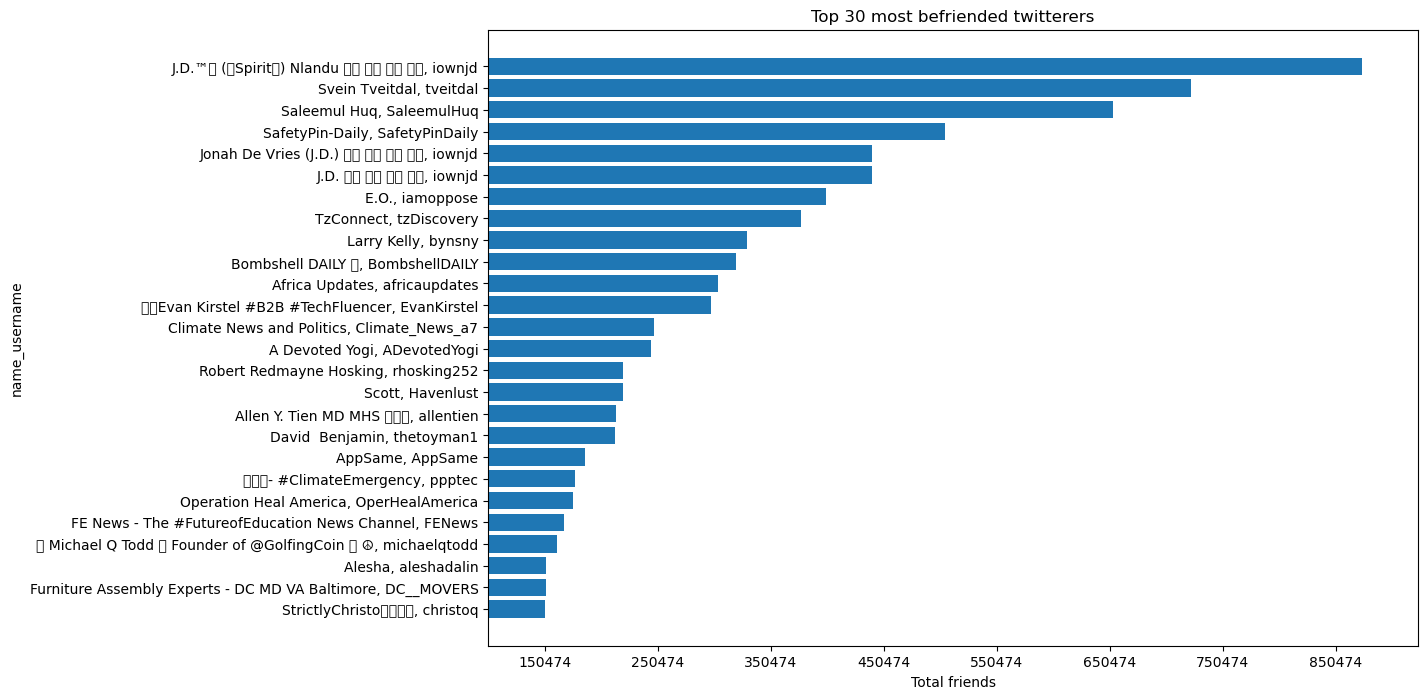

In [ ]:
# Bar Chart
plt.figure(figsize=(12, 8))
plt.barh(y=top_30_friends['name_username'], width=top_30_friends['sum(friends_count)'])
plt.xlabel('Total friends')
plt.xlim(top_30_friends['sum(friends_count)'].min()-50000, top_30_friends['sum(friends_count)'].max()+50000)
plt.xticks(range(top_30_friends['sum(friends_count)'].min(), top_30_friends['sum(friends_count)'].max(), 100000))
plt.ylabel('name_username')
plt.title('Top 30 most befriended twitterers')
plt.gca().invert_yaxis()
plt.show()

### Verified Accounts

In [ ]:
# Investigate how many verified accounts are there in the dataset 
verified_or_not = final_df.groupby('verified').agg(count(col('verified'))).toPandas()

In [ ]:
verified_or_not

,verified,count(verified)
0,True,2463
1,False,84850


In [ ]:
verified_or_not['count(verified)'].sum()

87313

In [ ]:
# adding a percentage column
verified_or_not['percent_of_total'] = (verified_or_not['count(verified)']/verified_or_not['count(verified)'].sum())*100
verified_or_not

,verified,count(verified),percent_of_total
0,True,2463,2.820886
1,False,84850,97.179114


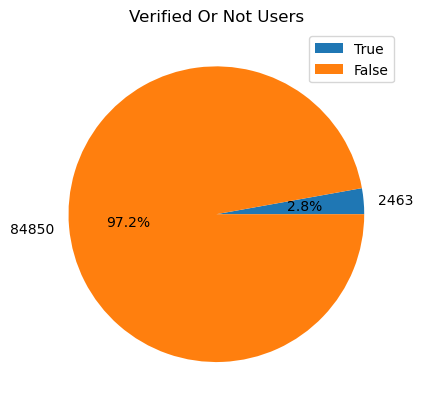

In [ ]:
# Pie Chart with percentages
plt.pie(verified_or_not['count(verified)'], labels=verified_or_not['count(verified)'], autopct='%1.1f%%')
plt.legend(verified_or_not['verified'])
plt.title('Verified Or Not Users')
plt.show()

### Top twitting locations

In [ ]:
# Aggregating location based on reply count
# Using the sum aggregarion function to add the metric across all tweets posted by the user
top_30_loc_reply = final_df.groupby('location').agg(sum('reply_count')).orderBy('sum(reply_count)',ascending=False).limit(29).toPandas()

In [ ]:
top_30_loc_reply

,location,sum(reply_count)
0,None,4698514
1,United States,238403
2,"California, USA",163403
3,"Los Angeles, CA",117936
4,USA,80627
5,"Texas, USA",62604
6,"Florida, USA",59250
7,California,47486
8,"Chicago, IL",45467
9,"San Francisco, CA",41756


In [ ]:
# Creating another location group column with states to aggregate the data 
top_30_loc_reply['loc_grp'] = np.where(top_30_loc_reply['location'].str.contains(r'San F|Cali|CA'), 'CA', 
                                       np.where((top_30_loc_reply['location']=='USA')|(top_30_loc_reply['location']=='United States'),'USA',
                                       np.where(top_30_loc_reply['location'].str.contains(r'DC'), 'DC',
                                       np.where(top_30_loc_reply['location'].str.contains(r'Flor|FL'),'FL',
                                       np.where(top_30_loc_reply['location'].str.contains(r'New Y|NY'), 'NY',
                                       np.where(top_30_loc_reply['location'].str.contains(r'OR'), 'OR',
                                       np.where(top_30_loc_reply['location'].str.contains(r'Mich'), 'MI',
                                       np.where(top_30_loc_reply['location'].str.contains(r'Massa|MA'), 'MA',
                                       np.where(top_30_loc_reply['location'].str.contains(r'Tex|TX'), 'TX',
                                       np.where(top_30_loc_reply['location'].str.contains(r'Ohio'), 'OH',
                                       np.where(top_30_loc_reply['location'].str.contains(r'Pen|PA'), 'PA',
                                       np.where(top_30_loc_reply['location'].str.contains(r'Seat'), 'WA',
                                       np.where(top_30_loc_reply['location'].str.contains(r'NV'), 'NV','')))))))))))))

# Removing the None entry to get a clearer percent frequency distribution across values
top_30_loc_reply = top_30_loc_reply.drop(index=0).reset_index(drop=True)

In [ ]:
top_30_loc_reply

,location,sum(reply_count),loc_grp
0,United States,238403,USA
1,"California, USA",163403,CA
2,"Los Angeles, CA",117936,CA
3,USA,80627,USA
4,"Texas, USA",62604,TX
5,"Florida, USA",59250,FL
6,California,47486,CA
7,"Chicago, IL",45467,
8,"San Francisco, CA",41756,CA
9,"Michigan, USA",38368,MI


In [ ]:
print('Unique Locations =',len(top_30_loc_reply['loc_grp'].unique()))

Unique Locations = 11


In [ ]:
# Group By by the grouped locations, top 12 unique locations
top_loc_reply = top_30_loc_reply.groupby('loc_grp')['sum(reply_count)'].sum()

In [71]:
pd.DataFrame(top_loc_reply)

,sum(reply_count)
loc_grp,
,276657
CA,407409
DC,31933
FL,59250
MA,30167
MI,38368
NY,62090
OH,30372
PA,31204


In [77]:
# Extracting the numbers
pies = []
for i in top_loc_reply:
    pies.append(i)
print(len(pies))

11


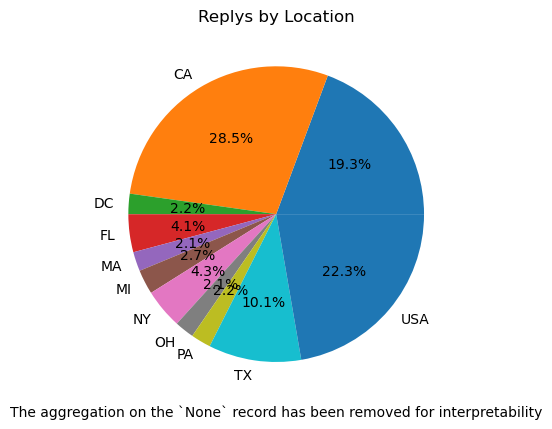

In [78]:
# Pie Chart
plt.pie(pies, labels=top_loc_reply.index.values, autopct='%1.1f%%')
plt.xlabel('The aggregation on the `None` record has been removed for interpretability')
plt.title('Replys by Location')
plt.show()

In [ ]:
# Aggregating Locations based on retweet count
# Using the sum aggregarion function to add the metric across all tweets posted by the user
top_30_loc_retwt = final_df.groupby('location').agg(sum('retweet_count')).orderBy('sum(retweet_count)',ascending=False).limit(27).toPandas()

In [ ]:
top_30_loc_retwt

,location,sum(retweet_count)
0,None,37097914
1,United States,2000076
2,"California, USA",1300832
3,"Los Angeles, CA",954322
4,USA,672649
5,"Texas, USA",486918
6,"Florida, USA",482744
7,"Chicago, IL",388143
8,California,362151
9,"Michigan, USA",330471


In [ ]:
# Creating another location group column with states to aggregate the data 
top_30_loc_retwt['loc_grp'] = np.where(top_30_loc_retwt['location'].str.contains(r'San F|Cali|CA'), 'CA', 
                                       np.where((top_30_loc_retwt['location']=='USA')|(top_30_loc_retwt['location']=='United States'),'USA',
                                       np.where(top_30_loc_retwt['location'].str.contains(r'DC'), 'DC',
                                       np.where(top_30_loc_retwt['location'].str.contains(r'Flor|FL'),'FL',
                                       np.where(top_30_loc_retwt['location'].str.contains(r'New Y|NY'), 'NY',
                                       np.where(top_30_loc_retwt['location'].str.contains(r'OR'), 'OR',
                                       np.where(top_30_loc_retwt['location'].str.contains(r'Mich'), 'MI',
                                       np.where(top_30_loc_retwt['location'].str.contains(r'Massa|MA'), 'MA',
                                       np.where(top_30_loc_retwt['location'].str.contains(r'Tex|TX'), 'TX',
                                       np.where(top_30_loc_retwt['location'].str.contains(r'Ohio'), 'OH',
                                       np.where(top_30_loc_retwt['location'].str.contains(r'Pen|PA'), 'PA',
                                       np.where(top_30_loc_retwt['location'].str.contains(r'Seat'), 'WA',''))))))))))))

# Removing the None entry to get a clearer percent frequency distribution across values
top_30_loc_retwt = top_30_loc_retwt.drop(index=0).reset_index(drop=True)

In [ ]:
print('Unique Locations =',len(top_30_loc_retwt['loc_grp'].unique()))

Unique Locations = 11


In [ ]:
# Group By by the grouped locations, top 12 unique locations
top_loc_retwt = top_30_loc_retwt.groupby('loc_grp')['sum(retweet_count)'].sum()

In [72]:
pd.DataFrame(top_loc_retwt)

,sum(retweet_count)
loc_grp,
,2057297
CA,3242097
DC,280472
FL,482744
MA,228702
MI,330471
NY,326922
OH,285318
PA,229232


In [79]:
# Extracting the numbers
pies = []
for i in top_loc_retwt:
    pies.append(i)

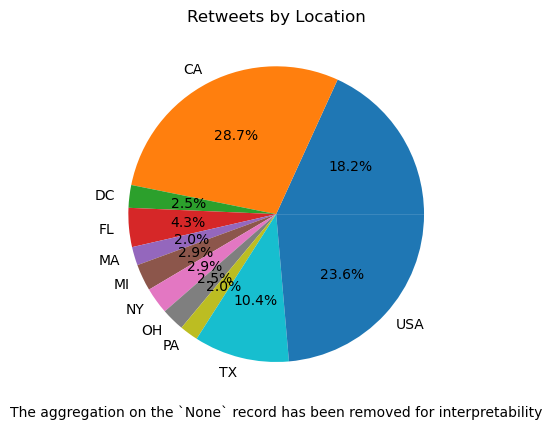

In [80]:
# Pie Chart
plt.pie(pies, labels=top_loc_retwt.index.values, autopct='%1.1f%%')
plt.xlabel('The aggregation on the `None` record has been removed for interpretability')
plt.title('Retweets by Location')
plt.show()

### Top twitting timelines

In [ ]:
# create new month and year columns for timelines analysis 
final_df =  final_df.withColumn('month',split(col('created_at'),' ')[1])
final_df =  final_df.withColumn('year',split(col('created_at'),' ')[5])
final_df.limit(5).toPandas()

,name,screen_name,verified,friends_count,followers_count,location,description,favourites_count,reply_count,retweet_count,created_at,tweet_text,name_username,month,year
0,Cambridge Computer Science,Cambridge_CL,False,322,7112,"Cambridge, England",Department of Computer Science and Technology at the University of Cambridge. Also known as the Cambridge Computer Laboratory. Established in 1937.,1706,NaN,NaN,Thu Feb 11 23:06:42 +0000 2016,"Hear our colleagues Anil Madhavapeddy @avsm, Director of the Cambridge Centre for Carbon Credits (4C), &amp; @emilyshuckburgh, Professor of Environmental Data Science, speak at Friday's William Pitt Seminar, part of the @CambridgeZero Climate Change Festival. https://t.co/c9AdUmgtap","Cambridge Computer Science, Cambridge_CL",Feb,2016
1,Chris 🇺🇸,1reconmarine1,False,182,227,None,None,4341,NaN,NaN,Wed Oct 08 14:45:42 +0000 2014,@RNCResearch Kamala Harris you’re a fucking moron three years ago when my son started college he had to teach his four roommates how to do laundry and use a fucking microwave climate change is a hoax,"Chris 🇺🇸, 1reconmarine1",Oct,2014
2,James Logan,James3point0,False,348,173,"New Orleans, LA","Nonprofit leader and philanthropist, reformed atty. Long suffering #Knicks #NUFC fan. Bed-Stuy native. All of the opinions outlined here are my own.",345,NaN,NaN,Thu Nov 04 03:12:30 +0000 2010,"The world is so small. My former @FordhamLawNYC professor, the brilliant @SheilaRFoster is moderating a great session on ""Mayors Taking on Climate Change"" at the @EGAconnects Fall Retreat. https://t.co/HjYNYa6zjO","James Logan, James3point0",Nov,2010
3,Top Ten Award International Network,TopTenAward,False,4703,471,"British Columbia, CANADA",An International Organization,1835,NaN,NaN,Thu Mar 24 07:36:21 +0000 2016,"S P E C I A L price for SCHOOLs &amp; LIBRARY The “International Manual of Climate Change Control” plus online tests &amp; certificates from Canada. Available in 39,000 bookstores globally\nhttps://t.co/KXbbHXjGkx\ninfo@ecofriendlyeducation.com\n #climatechange #coquitlam #canada","Top Ten Award International Network, TopTenAward",Mar,2016
4,Coquitlam Retweeter,CoquitlamRT,False,328,671,None,All things #Coquitlam as told by fellow tweeters. See pinned tweet. During Emergencies trust: @CityofCoquitlam @cqRCMP @EmergencyInfoBC,41,0.0,2.0,Wed Jul 05 02:08:09 +0000 2017,"S P E C I A L price for SCHOOLs &amp; LIBRARY The “International Manual of Climate Change Control” plus online tests &amp; certificates from Canada. Available in 39,000 bookstores globally\nhttps://t.co/KXbbHXjGkx\ninfo@ecofriendlyeducation.com\n #climatechange #coquitlam #canada","Coquitlam Retweeter, CoquitlamRT",Jul,2017


In [ ]:
# Monthly Total Sum of Retweets
month_retwt_sum = final_df.groupby('month').agg(sum('retweet_count')).orderBy('sum(retweet_count)',ascending=False).toPandas()

In [ ]:
month_retwt_sum

,month,sum(retweet_count)
0,Jan,9193398
1,Jun,8878898
2,Mar,8816195
3,Apr,8625845
4,May,8329229
5,Feb,8026642
6,Jul,7811768
7,Aug,7647029
8,Sep,7375276
9,Oct,7182390


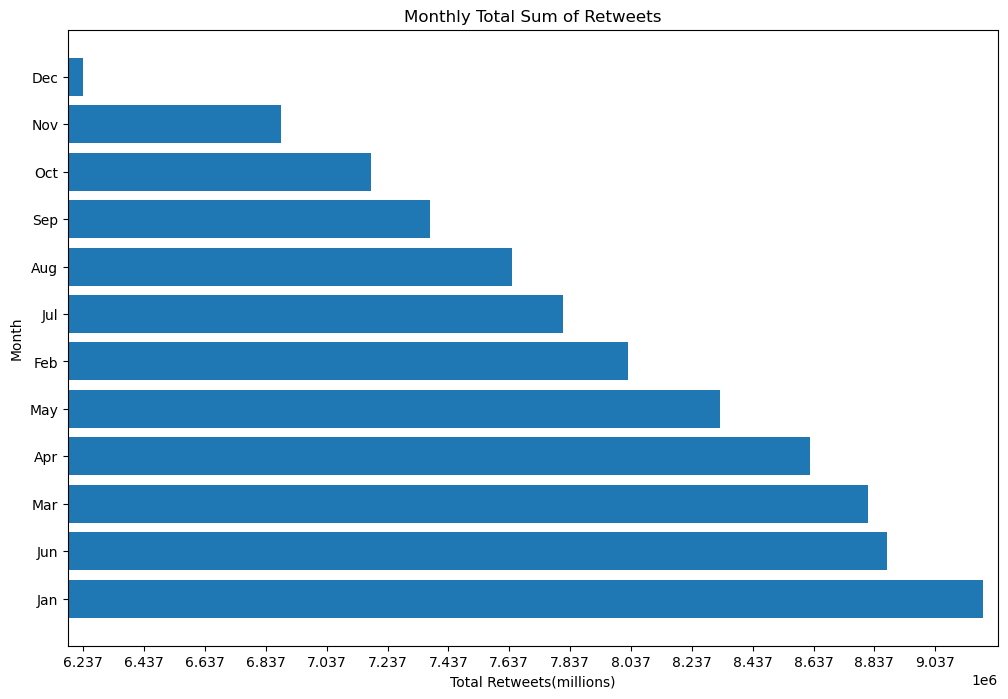

In [73]:
# Bar Chart
plt.figure(figsize=(12, 8))
plt.barh(y=month_retwt_sum['month'], width=month_retwt_sum['sum(retweet_count)'])
plt.xlabel('Total Retweets(millions)')
plt.xlim(month_retwt_sum['sum(retweet_count)'].min()-50000, month_retwt_sum['sum(retweet_count)'].max()+50000)
plt.xticks(range(month_retwt_sum['sum(retweet_count)'].min(), month_retwt_sum['sum(retweet_count)'].max(), 200000))
plt.ylabel('Month')
plt.title('Monthly Total Sum of Retweets')
plt.show()

In [ ]:
# Monthly Total Sum of Replies
month_reply_sum = final_df.groupby('month').agg(sum('reply_count')).orderBy('sum(reply_count)',ascending=False).toPandas()

In [ ]:
month_reply_sum

,month,sum(reply_count)
0,Jan,1152394
1,Jun,1118771
2,Apr,1110770
3,Mar,1105403
4,May,1018593
5,Feb,994607
6,Jul,971490
7,Aug,965230
8,Sep,927900
9,Oct,896414


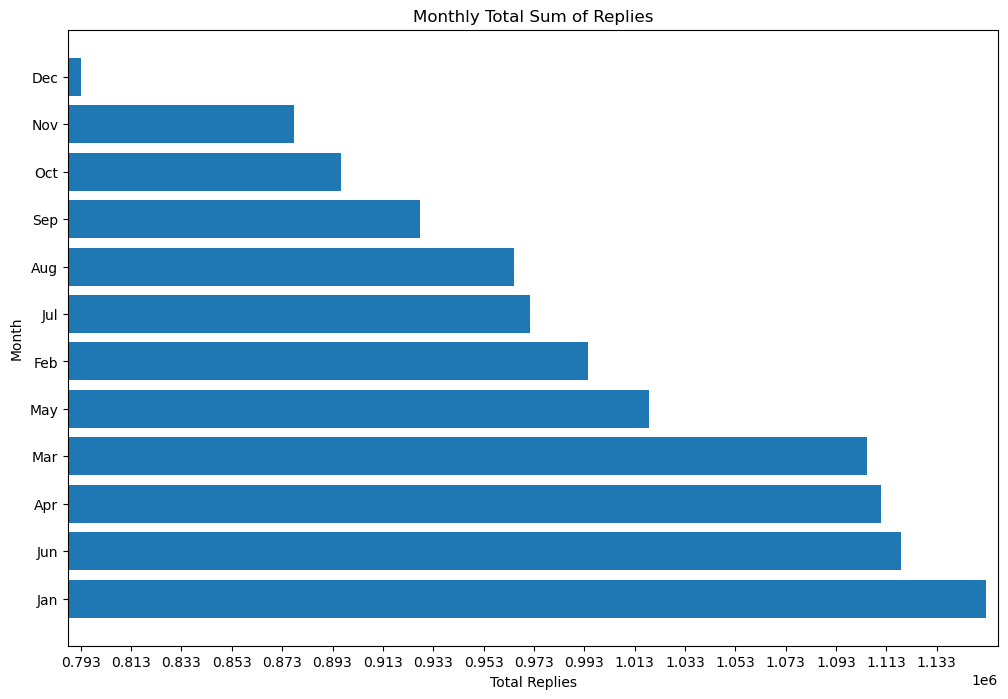

In [75]:
# Bar Chart
plt.figure(figsize=(12, 8))
plt.barh(y=month_reply_sum['month'], width=month_reply_sum['sum(reply_count)'])
plt.xlabel('Total Replies')
plt.xlim(month_reply_sum['sum(reply_count)'].min()-5000, month_reply_sum['sum(reply_count)'].max()+5000)
plt.xticks(range(month_reply_sum['sum(reply_count)'].min(), month_reply_sum['sum(reply_count)'].max(), 20000))
plt.ylabel('Month')
plt.title('Monthly Total Sum of Replies')
plt.show()

In [ ]:
# Yearly Total Sum of Retweets
year_retwt_sum = final_df.groupby('year').agg(sum('retweet_count')).orderBy('sum(retweet_count)',ascending=False).toPandas()

In [ ]:
year_retwt_sum

,year,sum(retweet_count)
0,2009,11459685
1,2012,8285620
2,2011,7482032
3,2020,7133388
4,2013,6641506
5,2017,6516416
6,2014,6366843
7,2022,6180985
8,2021,5969990
9,2016,5788080


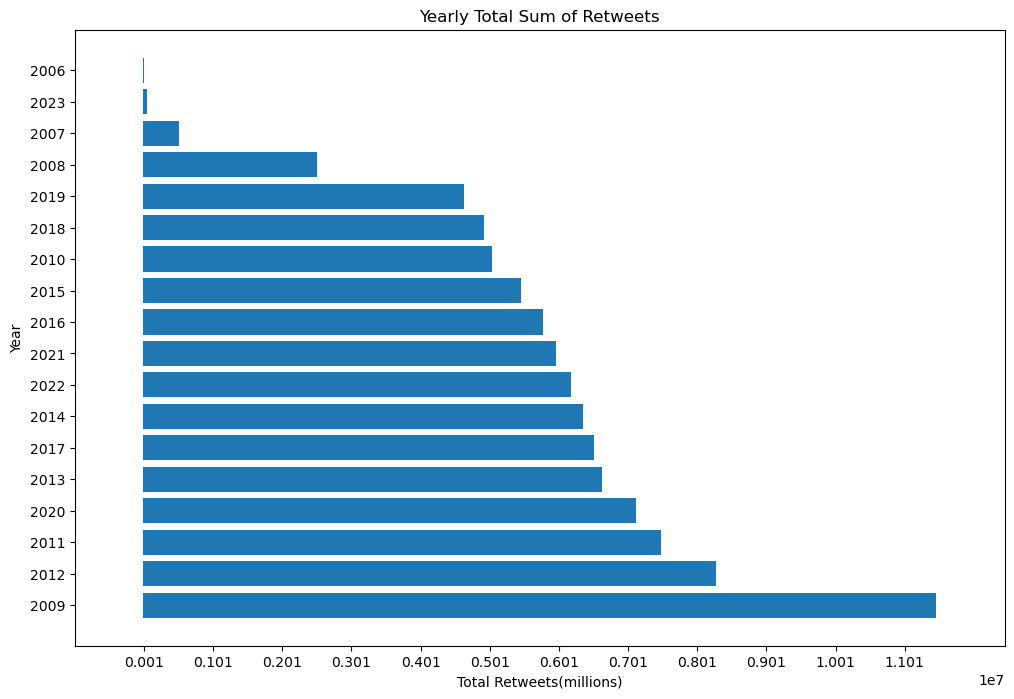

In [84]:
# Bar Chart
plt.figure(figsize=(12, 8))
plt.barh(y=year_retwt_sum['year'], width=year_retwt_sum['sum(retweet_count)'])
plt.xlabel('Total Retweets(millions)')
plt.xlim(year_retwt_sum['sum(retweet_count)'].min()-1000000, year_retwt_sum['sum(retweet_count)'].max()+1000000)
plt.xticks(range(year_retwt_sum['sum(retweet_count)'].min(), year_retwt_sum['sum(retweet_count)'].max(), 1000000))
plt.ylabel('Year')
plt.title('Yearly Total Sum of Retweets')
plt.show()

In [ ]:
# Yearly Total Sum of Replies
year_reply_sum = final_df.groupby('year').agg(sum('reply_count')).orderBy('sum(reply_count)',ascending=False).toPandas()

In [ ]:
year_reply_sum

,year,sum(reply_count)
0,2009,1421636
1,2012,1015427
2,2011,929386
3,2020,893523
4,2022,862389
5,2013,824288
6,2017,809076
7,2021,787824
8,2014,776779
9,2016,722080


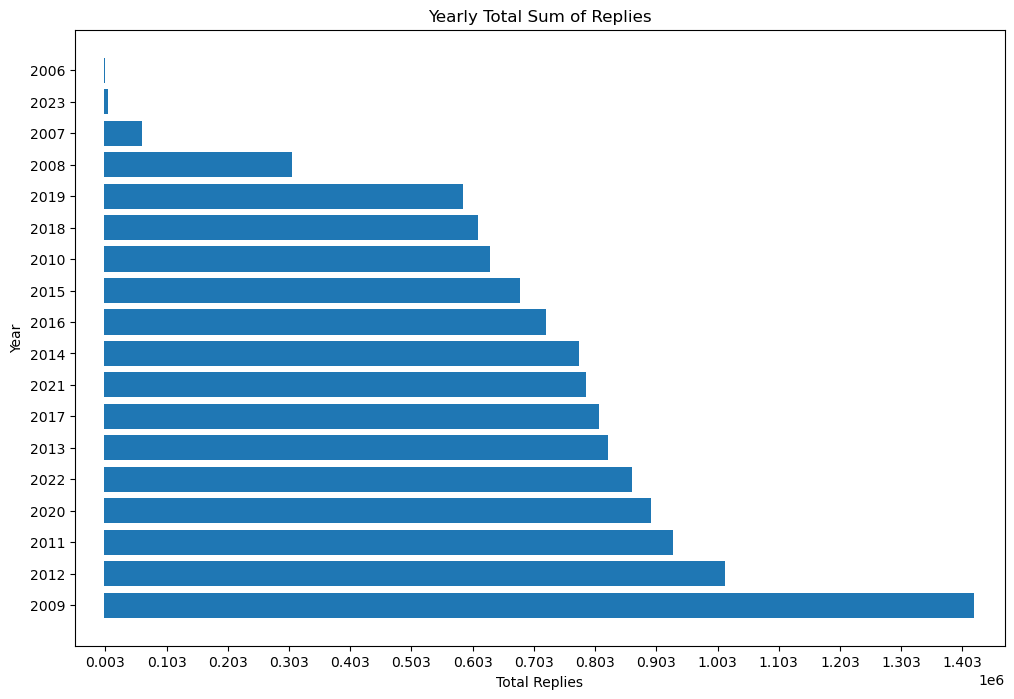

In [85]:
# Bar Chart
plt.figure(figsize=(12, 8))
plt.barh(y=year_reply_sum['year'], width=year_reply_sum['sum(reply_count)'])
plt.xlabel('Total Replies')
plt.xlim(year_reply_sum['sum(reply_count)'].min()-50000, year_reply_sum['sum(reply_count)'].max()+50000)
plt.xticks(range(year_reply_sum['sum(reply_count)'].min(), year_reply_sum['sum(reply_count)'].max(), 100000))
plt.ylabel('Year')
plt.title('Yearly Total Sum of Replies')
plt.show()